## Centralized training

- Explore hyperparameters 
- Check that the model can learn in a centralized setting (setup sanity check)
- Get approximately the global centralized loss value it can reach. To be compared with federated setting.

In [16]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy as np
import json
import os

# set cwd
os.chdir("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/analysis")

centralized_training_loss = glob.glob(f"../results_centralized_hyperparam/**/centralized_training/**/loss_per_epoch.csv", recursive=True)
print(f"Found {len(centralized_training_loss)} files")


Found 60 files


In [17]:
# For each file in the list, read the meta.csv file and extract lr  and read in the loss_per_epoch.csv file
def read_loss_file(file):
    # Read the meta.csv file
    meta_file = file.replace("loss_per_epoch.csv", "meta.csv")
    meta_data = pd.read_csv(meta_file)
    lr = meta_data['lr'].item()
    clipping = meta_data['gradientclipping'].item()
    bs = meta_data['batch_size'].item()
    lrdecay = meta_data['lrdecay'].item()
    
    # Read the loss_per_epoch.csv file
    loss_df = pd.read_csv(file)
    
    # Add the learning rate to the DataFrame
    loss_df['lr'] = lr
    loss_df['clipping'] = clipping
    loss_df['batch_size'] = bs
    loss_df['lrdecay'] = lrdecay
    
    return loss_df
# Read all the loss files and concatenate them into a single DataFrame
loss_dfs = []
for file in centralized_training_loss:
    loss_df = read_loss_file(file)
    loss_dfs.append(loss_df)
loss_df = pd.concat(loss_dfs, ignore_index=True)
# Convert the epoch column to a numeric type
loss_df["epoch"] = pd.to_numeric(loss_df["epoch"], errors='coerce')
# add 1
loss_df["epoch"] = loss_df["epoch"] + 1
df_centralized_training_loss = loss_df

# combine all but loss into hyperparam column
def combine_hyperparams(row):
    return f"lr: {row['lr']}, clipping: {row['clipping']}, batch_size: {row['batch_size']}, lrdecay: {row['lrdecay']}"
# apply the function to each row
df_centralized_training_loss['hyperparams'] = df_centralized_training_loss.apply(combine_hyperparams, axis=1)

# plot uniqure values of lr and clipping
unique_lrs = df_centralized_training_loss['lr'].unique()
unique_clippings = df_centralized_training_loss['clipping'].unique()
unique_batch_sizes = df_centralized_training_loss['batch_size'].unique()
print("Unique learning rates:", unique_lrs)
print("Unique clipping values:", unique_clippings)
print("Unique batch sizes:", unique_batch_sizes)


# prepare the data for plotting
df_loss_long = pd.concat([
    df_centralized_training_loss[['epoch', 'lr', 'batch_size','lrdecay', 'hyperparams', 'train_loss']].rename(columns={'train_loss': 'loss'}).assign(type='train'),
    df_centralized_training_loss[['epoch', 'lr', 'batch_size','lrdecay', 'hyperparams', 'val_loss']].rename(columns={'val_loss': 'loss'}).assign(type='val')
], ignore_index=True)


training = df_loss_long[df_loss_long['type'] == 'train']
validation = df_loss_long[df_loss_long['type'] == 'val']

Unique learning rates: [0.1   0.001 0.01 ]
Unique clipping values: [False]
Unique batch sizes: [ 64  50  16 100  32]


### Check which batchsize

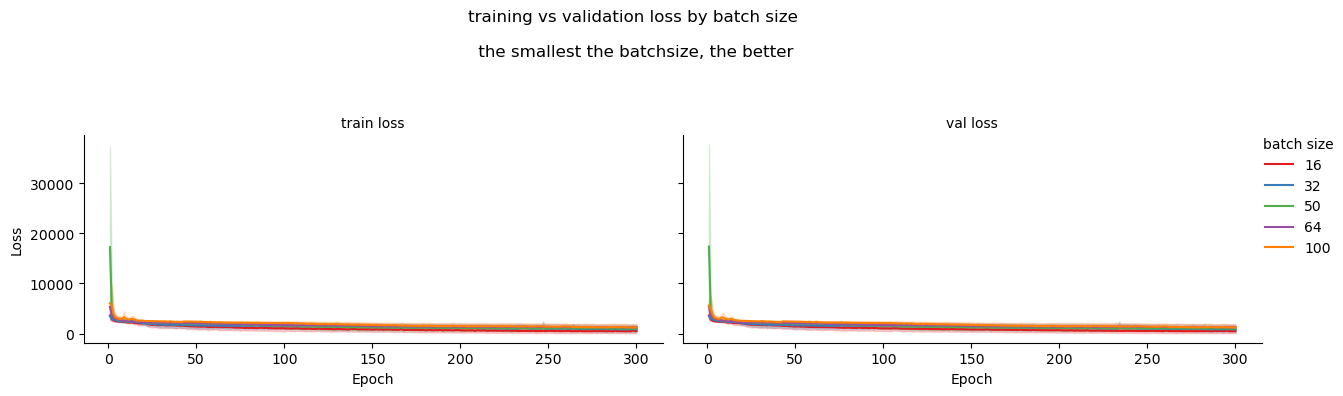

In [18]:

g = sns.FacetGrid(df_loss_long, col="type", height=4, aspect=1.5, sharey=True)

g.map_dataframe(
    sns.lineplot,
    x="epoch",
    y="loss",
    hue="batch_size",
    palette="Set1"
)

g.set_axis_labels("Epoch", "Loss")
g.set_titles(col_template="{col_name} loss")
g.add_legend(title="batch size")
g._legend.set_bbox_to_anchor((1.05, 0.5))
g.fig.suptitle("training vs validation loss by batch size \n\n the smallest the batchsize, the better \n\n", fontsize=12)
plt.tight_layout()
# log scale y axis

plt.show()


### Check which learning rate

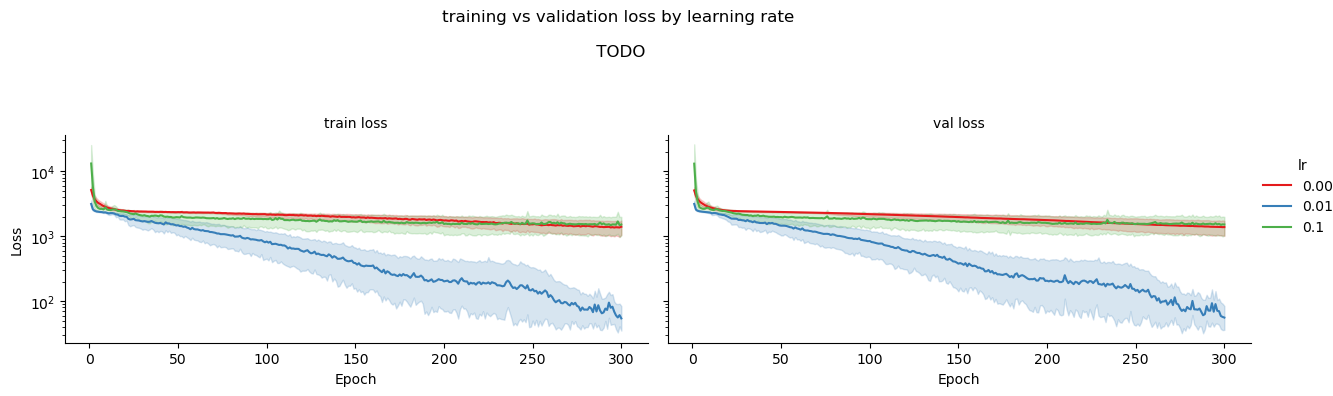

In [19]:
g = sns.FacetGrid(df_loss_long, col="type", height=4, aspect=1.5, sharey=True)

g.map_dataframe(
    sns.lineplot,
    x="epoch",
    y="loss",
    hue="lr",
    palette="Set1"
)

g.set_axis_labels("Epoch", "Loss")
g.set_titles(col_template="{col_name} loss")
g.add_legend(title="lr")
g._legend.set_bbox_to_anchor((1.05, 0.5))
g.fig.suptitle("training vs validation loss by learning rate \n\n TODO \n\n", fontsize=12)
plt.tight_layout()
# plot log scale y axis
plt.yscale('log')
plt.show()


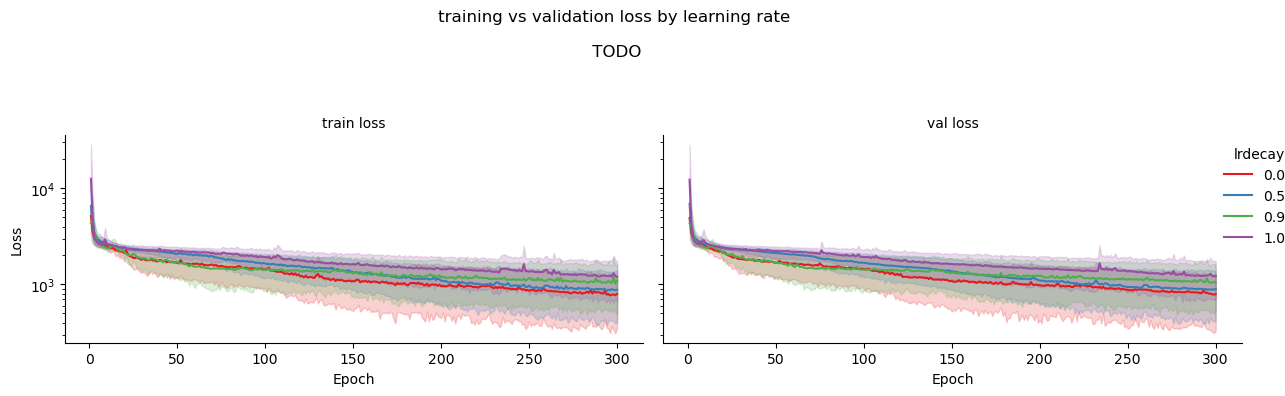

In [20]:
g = sns.FacetGrid(df_loss_long, col="type", height=4, aspect=1.5, sharey=True)

g.map_dataframe(
    sns.lineplot,
    x="epoch",
    y="loss",
    hue="lrdecay",
    palette="Set1"
)

g.set_axis_labels("Epoch", "Loss")
g.set_titles(col_template="{col_name} loss")
g.add_legend(title="lrdecay")
g._legend.set_bbox_to_anchor((1.02, 0.5))
g.fig.suptitle("training vs validation loss by learning rate \n\n TODO \n\n", fontsize=12)
plt.tight_layout()
# plot log scale y axis
plt.yscale('log')
plt.show()

### Go more in depth 

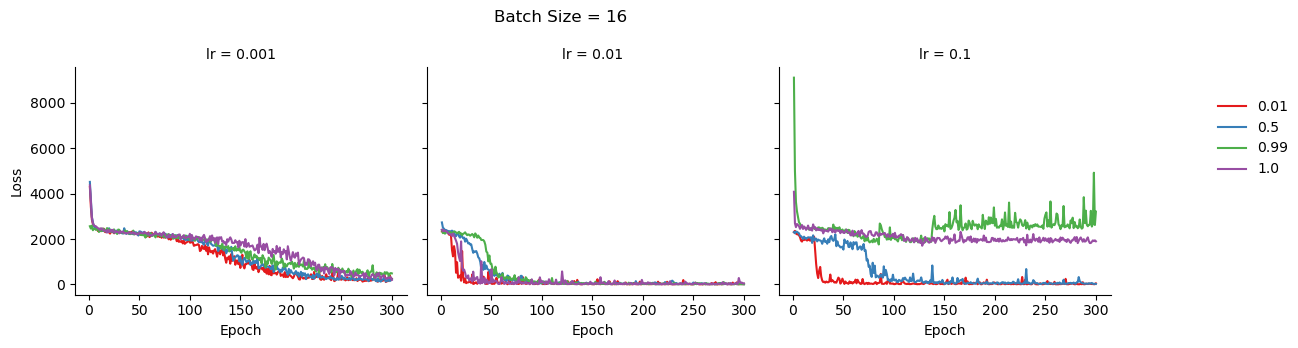

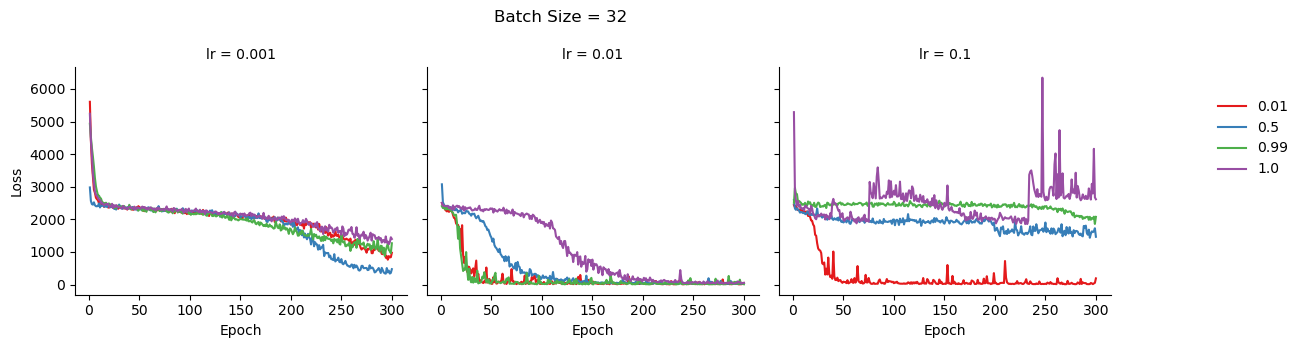

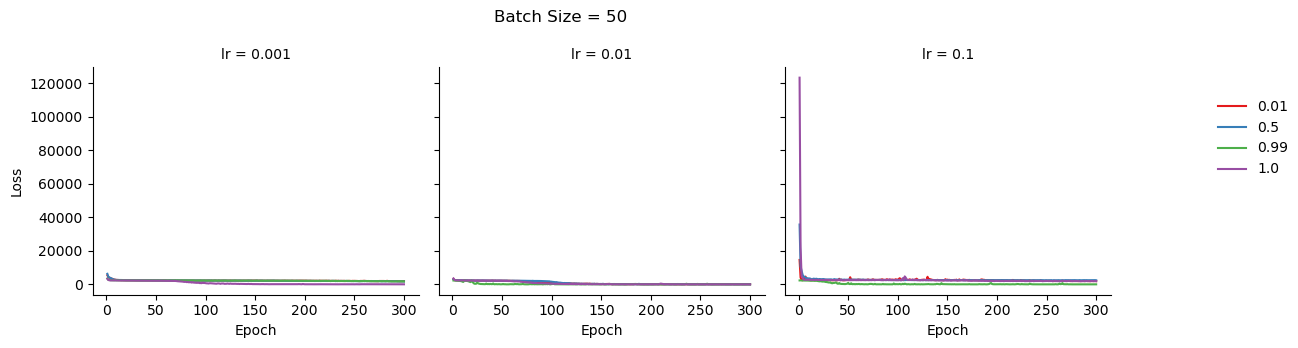

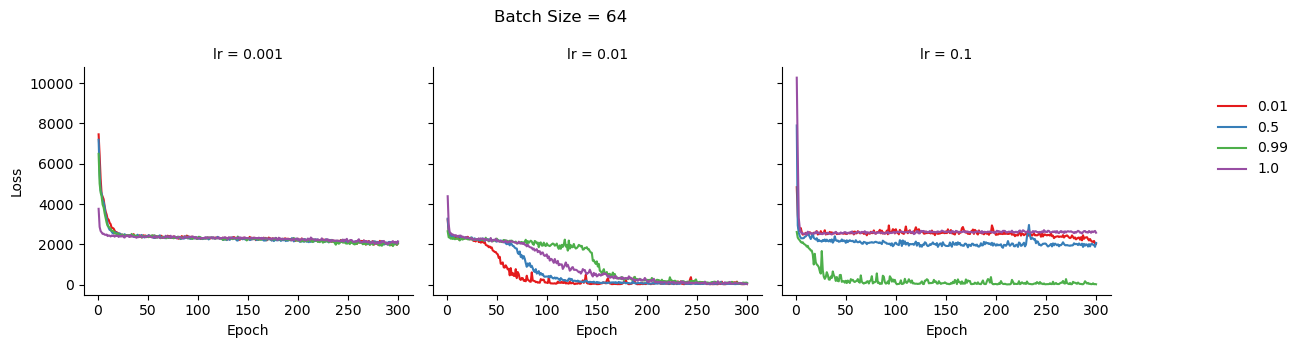

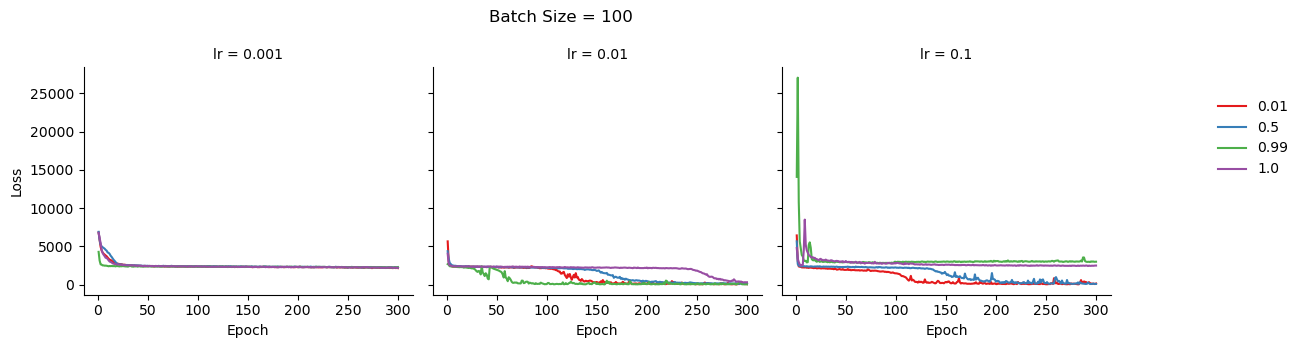

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Loop over each unique batch size
for batch_size in sorted(training['batch_size'].unique()):
    tr_batch = training[training['batch_size'] == batch_size]

    g = sns.FacetGrid(tr_batch, col='lr', col_wrap=3, height=3.5, sharey=True)

    g.map_dataframe(
        sns.lineplot,
        x='epoch',
        y='loss',
        hue='lrdecay',
        palette='Set1',
        legend='brief'
    )

    g.set_axis_labels('Epoch', 'Loss')
    g.set_titles(col_template='lr = {col_name}')
    g.fig.subplots_adjust(top=0.85)  # leave space for main title
    g.fig.suptitle(f"Batch Size = {batch_size}", fontsize=12)

    # move legend outside
    g.add_legend()
    g._legend.set_bbox_to_anchor((1.15, 0.6))
    # y log
   
    plt.tight_layout()
    plt.show()


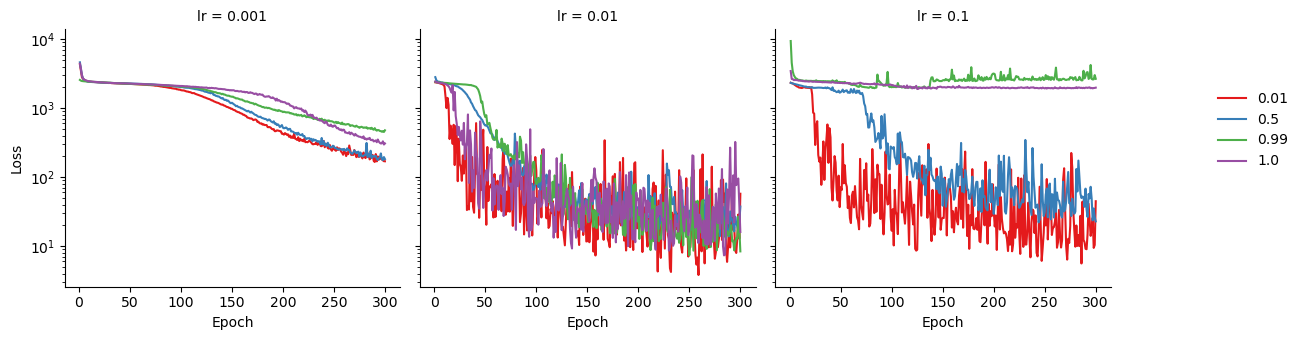

In [22]:
# Add title of type 

# add main title 
tr_16 = validation[validation['batch_size'] == 16]

g = sns.FacetGrid(tr_16, col='lr', col_wrap=3, height=3.5, sharey=True)

g.map_dataframe(
    sns.lineplot,
    x='epoch',
    y='loss',
    hue='lrdecay',
    palette='Set1',
    legend='brief'
)

g.set_axis_labels('Epoch', 'Loss')
g.add_legend()
# add legend outside
g._legend.set_bbox_to_anchor((1.15, 0.6))
g.set_titles(col_template='lr = {col_name}')
# log scale y axis
plt.yscale('log')
plt.tight_layout()
plt.show()

# TODO 
# check how close we can get
# Plot outputs
# weight divergence tracking ( ODE vs avg, centralized global vs federated  )

# Plot best combination of hyperparameters 

In [34]:
best_bs =16
best_lr = 0.01
best_decay = 0.01
df_plot = df_centralized_training_loss[
    (df_centralized_training_loss['batch_size'] == best_bs) &
    (df_centralized_training_loss['lr'] == best_lr) &
    (df_centralized_training_loss['lrdecay'] == best_decay)
]
# combine lr, clipping and batch size into a single column
df_plot['lr_decay_bs'] = df_plot['lr'].astype(str) + "_" + df_plot['lrdecay'].astype(str) + "_" + df_plot['batch_size'].astype(str)

/var/folders/yx/rfhrpk093hz1gfwtn7qxt_180000gq/T/ipykernel_67807/1821569116.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['lr_decay_bs'] = df_plot['lr'].astype(str) + "_" + df_plot['lrdecay'].astype(str) + "_" + df_plot['batch_size'].astype(str)


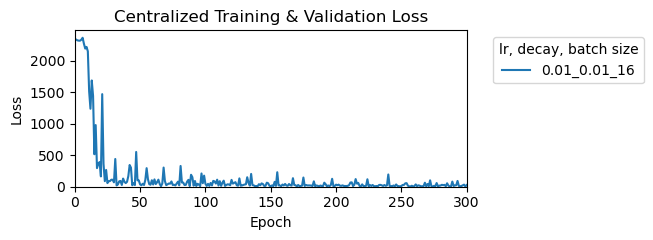

In [35]:
plt.figure(figsize=(5, 2.5))

# # Plot training loss
sns.lineplot(
    data=df_plot,
    x='epoch',
    y='train_loss',
    hue='lr_decay_bs',
    palette='tab10'
)
reds = sns.color_palette("Reds", n_colors=5)

# # Plot validation loss
# sns.lineplot(
#     data=df_centralized_training_loss,
#     x='epoch',
#     y='val_loss',
#     hue='lr',
#     palette=reds,
#     linestyle='--',
#     legend=False,
# )

plt.ylim(bottom=0)
plt.xlim(left=0, right=20)
plt.xticks(ticks=range(0, df_plot['epoch'].max() + 1, 50))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Centralized Training & Validation Loss')
plt.tight_layout()
plt.legend(title="lr, decay, batch size", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [36]:
# Get the min loss
min_train_loss = df_plot['train_loss'].min()
min_val_loss = df_plot['val_loss'].min()
print(f"Minimum training loss: {min_train_loss}")
print(f"Minimum validation loss: {min_val_loss}")

Minimum training loss: 3.294650077819824
Minimum validation loss: 3.80214131795443
